In [1]:
from plots.mpltoolkit import named_colors, mpl_loc, markers, fancy_legend, load_style_sheet
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from scipy.stats import linregress
import numpy as np
import random
import vice
import sys
sys.path.append("..")
from src.stats import skewnormal_mode_sample, jackknife_summary_statistic
load_style_sheet("papers")
# load_mpl_presets()
# mpl.rcParams["axes.linewidth"] = 0.5
# mpl.rcParams["figure.titlesize"] = 14
# mpl.rcParams["axes.titlesize"] = 14
# mpl.rcParams["axes.labelsize"] = 14
# mpl.rcParams["xtick.labelsize"] = 14
# mpl.rcParams["ytick.labelsize"] = 14
# mpl.rcParams["legend.fontsize"] = 14
# mpl.rcParams["errorbar.capsize"] = 1
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=13, releaselevel='final', serial=0)


In [2]:
# output = "../outputs/inside-out/eta-0/fiducial-subeq"
output = "../outputs/inside-out/eta-eR/yieldsolar3"
output = vice.output(output)
extra = np.genfromtxt("%s_analogdata.out" % (output.name))
output.stars["absz"] = [abs(_) for _ in extra[:, -1][:output.stars.size[0]]]

In [3]:
def plot_data(ax, filename, **kwargs):
    raw = np.genfromtxt(filename)
    centers = [(a + b) / 2 for a, b in zip(raw[:, 0], raw[:, 1])]
    ax.plot(raw[:, 2], centers, linestyle = ":", **kwargs)
    ax.plot(raw[:, 4], centers, linestyle = ":", **kwargs)
    ax.plot(raw[:, 3], centers, **kwargs)

def plot_model(ax, stars, key, min_rgal = 7, max_rgal = 9, zone_width = 0.1,
    bins = np.arange(-3, 1, 0.05), **kwargs):
    lower, median, upper = get_model_ages(stars, key, min_rgal = min_rgal,
        max_rgal = max_rgal, zone_width = zone_width, bins = bins)
    kwargs["xerr"] = [
        [(m - l) for m, l in zip(median, lower)],
        [(u - m) for u, m in zip(upper, median)]
    ]
    centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    ax.errorbar(median, centers, **kwargs)

def get_model_ages(stars, key, min_rgal = 7, max_rgal = 9, zone_width = 0.1,
    bins = np.arange(-3, 1, 0.05)):
    stars = stars.filter(
        "zone_final", ">=", int(min_rgal / zone_width)).filter(
        "zone_final", "<=", int(max_rgal / zone_width)).filter(
        "absz", "<=", 0.5).filter(
        "mass", ">=", 1)
    lower = (len(bins) - 1) * [None]
    median = (len(bins) - 1) * [None]
    upper = (len(bins) - 1) * [None]
    for i in range(len(bins) - 1):
        sub = stars.filter(
            key, ">=", bins[i]).filter(
            key, "<=", bins[i + 1])
        if len(sub["age"]) > 20:
            indeces = np.argsort(sub["age"])
            norm = 0
            for idx in indeces: norm += sub["age"][idx] * sub["mass"][idx]
            s = 0
            for idx in indeces:
                s += sub["age"][idx] * sub["mass"][idx] / norm
                if s > 0.16 and lower[i] is None: lower[i] = sub["age"][idx]
                if s > 0.5 and median[i] is None: median[i] = sub["age"][idx]
                if s > 0.84 and upper[i] is None: upper[i] = sub["age"][idx]
        else:
            lower[i] = float("nan")
            median[i] = float("nan")
            upper[i] = float("nan")
    return [lower, median, upper]

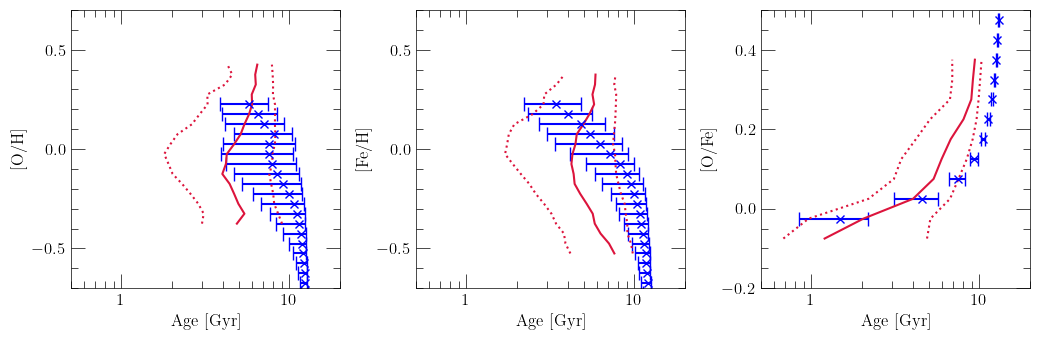

In [5]:
MIN_RGAL = 7 # kpc
MAX_RGAL = 9 # kpc
ZONE_WIDTH = 0.1 # kpc
BINS = np.arange(-3, 1, 0.05)

fig = plt.figure(figsize = (10.5, 3.5))
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
    axes[i].set_xscale("log")
    axes[i].xaxis.set_major_formatter(fsf("%g"))
    axes[i].set_xlabel(r"Age [Gyr]")
    axes[i].set_xlim([0.5, 20])
axes[0].set_ylabel("[O/H]")
axes[0].set_ylim([-0.7, 0.7])
axes[0].set_yticks([-0.5, 0, 0.5])
axes[1].set_ylabel("[Fe/H]")
axes[1].set_ylim([-0.7, 0.7])
axes[1].set_yticks([-0.5, 0, 0.5])
axes[2].set_ylabel("[O/Fe]")
axes[2].set_ylim([-0.2, 0.5])
axes[2].set_yticks([-0.2, 0, 0.2, 0.4])

analysis_kwargs = {
    "min_rgal": MIN_RGAL,
    "max_rgal": MAX_RGAL,
    "zone_width": ZONE_WIDTH,
    "bins": BINS
}
plot_kwargs = {
    "linestyle": "None",
    "marker": markers()["x"],
    "color": named_colors()["blue"]
}
plot_model(axes[0], output.stars, "[o/h]", **analysis_kwargs, **plot_kwargs)
plot_model(axes[1], output.stars, "[fe/h]", **analysis_kwargs, **plot_kwargs)
plot_model(axes[2], output.stars, "[o/fe]", **analysis_kwargs, **plot_kwargs)

plot_data(axes[0], "./empirical/amr-7-9-o_h.out", c = named_colors()["crimson"])
plot_data(axes[1], "./empirical/amr-7-9-fe_h.out", c = named_colors()["crimson"])
plot_data(axes[2], "./empirical/amr-7-9-o_fe.out", c = named_colors()["crimson"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./amr/eta-eR-yieldsolar3.%s" % (ext), **kwargs)
plt.show()

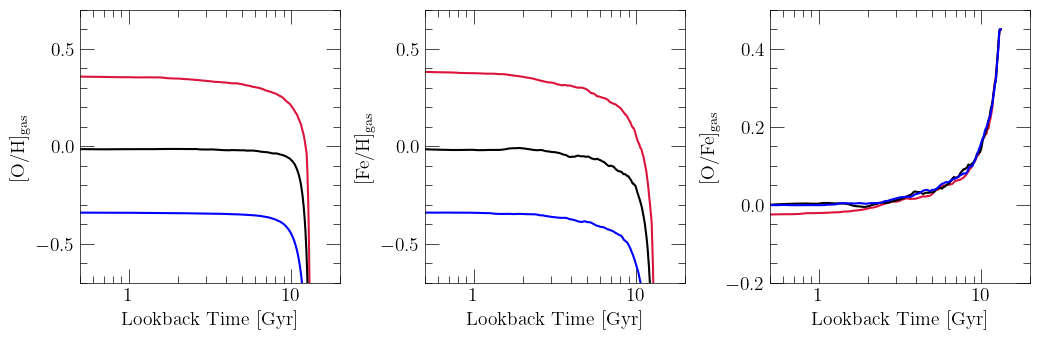

In [48]:
RADII = [4, 8, 12]
RADII_COLORS = ["crimson", "black", "blue"]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (10.5, 3.5))
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
    axes[i].set_xscale("log")
    axes[i].xaxis.set_major_formatter(fsf("%g"))
    axes[i].set_xlabel(r"Lookback Time [Gyr]")
    axes[i].set_xlim([0.5, 20])
axes[0].set_ylabel(r"[O/H]$_\text{gas}$")
axes[0].set_ylim([-0.7, 0.7])
axes[0].set_yticks([-0.5, 0, 0.5])
axes[1].set_ylabel(r"[Fe/H]$_\text{gas}$")
axes[1].set_ylim([-0.7, 0.7])
axes[1].set_yticks([-0.5, 0, 0.5])
axes[2].set_ylabel(r"[O/Fe]$_\text{gas}$")
axes[2].set_ylim([-0.2, 0.5])
axes[2].set_yticks([-0.2, 0, 0.2, 0.4])

def plot_predictions(axes, output, radius, **kwargs):
    zone = int(radius / ZONE_WIDTH)
    zone = output.zones["zone%d" % (zone)]
    axes[0].plot(zone.history["lookback"], zone.history["[o/h]"], **kwargs)
    axes[1].plot(zone.history["lookback"], zone.history["[fe/h]"], **kwargs)
    axes[2].plot(zone.history["lookback"], zone.history["[o/fe]"], **kwargs)

for i in range(len(RADII)):
    kwargs = {
        "c": named_colors()[RADII_COLORS[i]],
        "label": "%d kpc" % (RADII[i])
    }
    plot_predictions(axes, output, RADII[i], **kwargs)

plt.tight_layout()
plt.show()